## ECON470 Homework 3-3
Author: Sarina Tan

In [1]:
# Importing the libraries 
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from tabulate import tabulate
from statsmodels.formula.api import ols
from linearmodels.iv import IV2SLS
from causalinference import CausalModel
from sklearn.neighbors import NearestNeighbors
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')

1. Present a bar graph showing the proportion of states with a change in their cigarette tax in each year from 1970 to 1985.

In [2]:
# Load data
df = pd.read_csv("/Users/sarinatan/Desktop/HLTH470hw3/data/output/TaxBurden_Data.csv")
# Focus only on years 1970-1985
df_q1 = df.copy()

df_q1 = df_q1[(df_q1['Year'] >= 1970) & (df_q1['Year'] <= 1985)]
# Sort data
df_q1 = df_q1.sort_values(by=['state', 'Year'])

In [6]:
df_q1['tax_change'] = df_q1.groupby('state')['tax_state'].diff().ne(0)
# Calculate proportion of states with a tax change each year
tax_change_proportion = df_q1.groupby('Year')['tax_change'].mean()

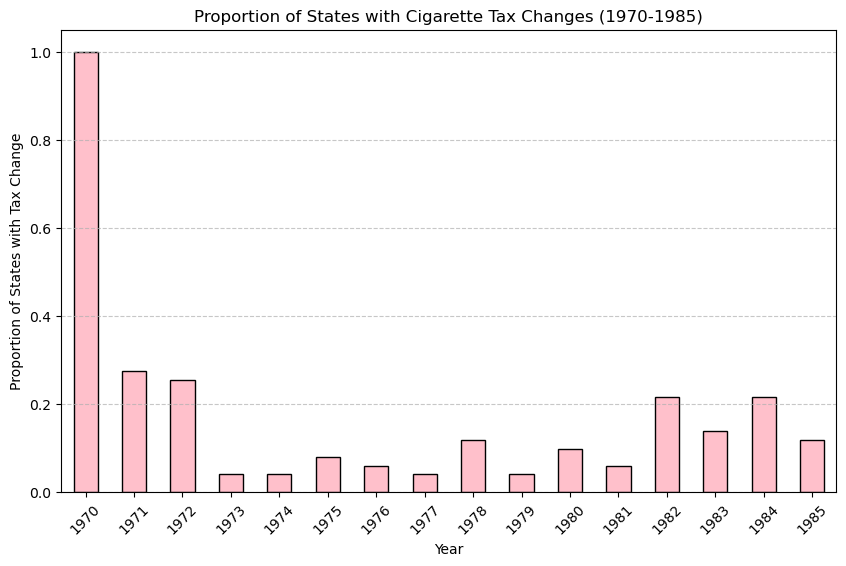

In [26]:

# Prepare graph
plt.figure(figsize=(10,6))
tax_change_proportion.plot(kind='bar', color='pink', edgecolor='black')
plt.title('Proportion of States with Cigarette Tax Changes (1970-1985)')
plt.xlabel('Year')
plt.ylabel('Proportion of States with Tax Change')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

2. Plot on a single graph the average tax (in 2012 dollars) on cigarettes and the average price of a pack of cigarettes from 1970 to 2018.

In [8]:
df_q2 = df.copy()
# Filter for years 1970 to 2018
df_q2 = df_q2[(df_q2['Year'] >= 1970) & (df_q2['Year'] <= 2018)]

# Use CPI to adjust to 2012 dollars
# Assuming 2012 CPI = 230 (You should check the exact CPI value for 2012 from your dataset if available)
df_q2['cost_per_pack_2012'] = df_q2['cost_per_pack'] * (230 / df_q2['index'])
df_q2['tax_state_2012'] = df_q2['tax_state'] * (230 / df_q2['index'])

# Group by year and compute average across all states
annual_avg = df_q2.groupby('Year').agg({
    'cost_per_pack_2012': 'mean',
    'tax_state_2012': 'mean'
}).reset_index()

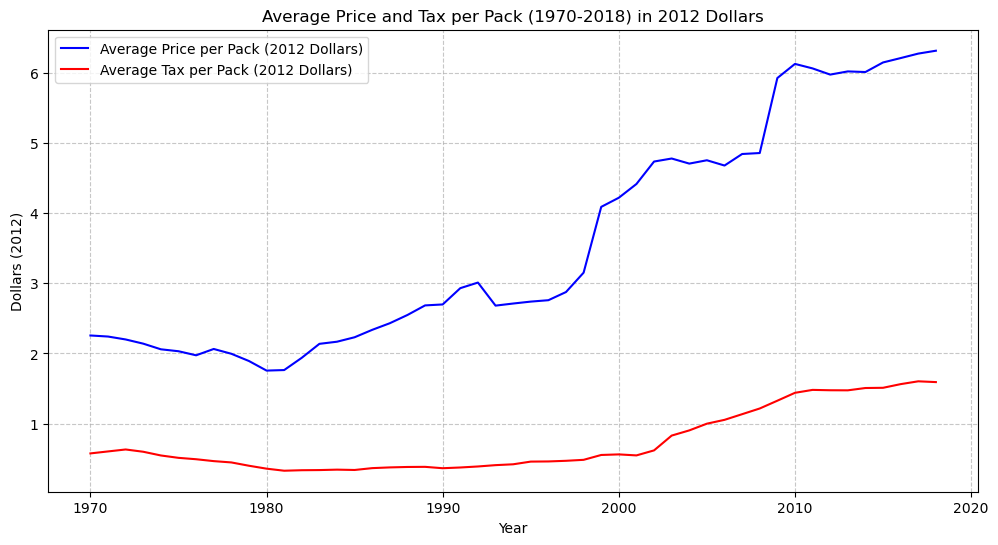

In [9]:
# Plot
plt.figure(figsize=(12, 6))

plt.plot(annual_avg['Year'], annual_avg['cost_per_pack_2012'], label='Average Price per Pack (2012 Dollars)', color='blue')
plt.plot(annual_avg['Year'], annual_avg['tax_state_2012'], label='Average Tax per Pack (2012 Dollars)', color='red')

plt.title('Average Price and Tax per Pack (1970-2018) in 2012 Dollars')
plt.xlabel('Year')
plt.ylabel('Dollars (2012)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

3. Identify the 5 states with the highest increases in cigarette prices (in dollars) over the time period. Plot the average number of packs sold per capita for those states from 1970 to 2018.

In [30]:
# Create separate copy for this question
df_q3 = df.copy()

# Filter for years 1970-2018
df_q3 = df_q3[(df_q3['Year'] >= 1970) & (df_q3['Year'] <= 2018)]

# Compute the price difference between 1970 and 2018
price_change = df_q3.groupby('state')['price_cpi'].agg(['first', 'last'])
price_change['price_increase'] = price_change['last'] - price_change['first']

# Identify the 5 states with the highest price increase
top_5_states = price_change.nlargest(5, 'price_increase').index.tolist()
print("Top 5 states with highest price increase:", top_5_states)

# Filter dataset for these states only
df_q3 = df_q3[df_q3['state'].isin(top_5_states)]

# Compute the average packs sold per capita for these states each year
avg_sales_per_year = df_q3.groupby(['Year', 'state'])['sales_per_capita'].mean().unstack()

Top 5 states with highest price increase: ['District of Columbia', 'New York', 'Rhode Island', 'Hawaii', 'Massachusetts']


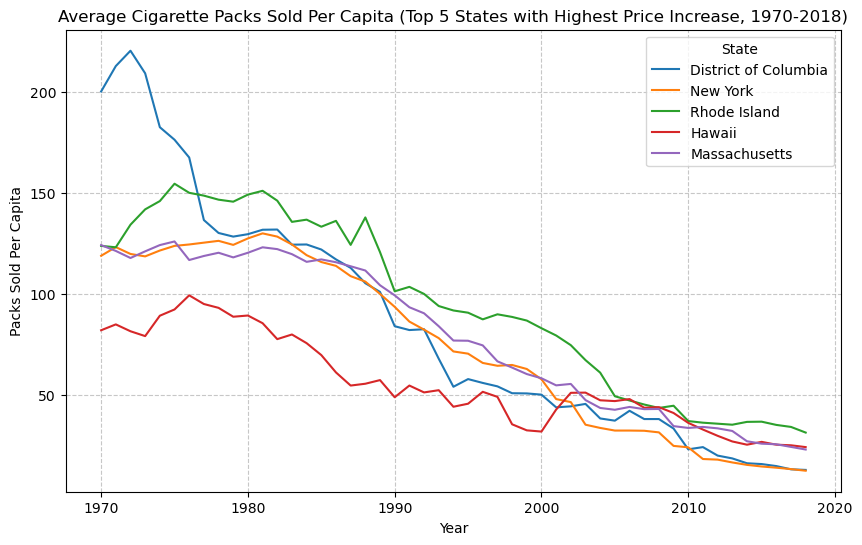

In [11]:
# Plot the trend for each of the top 5 states
plt.figure(figsize=(10, 6))
for state in top_5_states:
    plt.plot(avg_sales_per_year.index, avg_sales_per_year[state], label=state)

# Format Graph
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.title('Average Cigarette Packs Sold Per Capita (Top 5 States with Highest Price Increase, 1970-2018)')
plt.legend(title='State')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

4. Identify the 5 states with the lowest increases in cigarette prices over the time period. Plot the average number of packs sold per capita for those states from 1970 to 2018.

In [12]:
# Create seperate copy for this question
df_q4 = df.copy()

# Filter for years 1970-2018
df_q4 = df_q4[(df_q4['Year'] >= 1970) & (df_q4['Year'] <= 2018)]

# Compute the price difference between 1970 and 2018
price_change = df_q4.groupby('state')['price_cpi'].agg(['first', 'last'])
price_change['price_increase'] = price_change['last'] - price_change['first']

# Identify the 5 states with the lowest price increase
bottom_5_states = price_change.nsmallest(5, 'price_increase').index.tolist()
print("Bottom 5 states with lowest price increase:", bottom_5_states)

# Filter the dataset for these states only
df_q4 = df_q4[df_q4['state'].isin(bottom_5_states)]

# Compute the average packs sold per capita for these states each year
avg_sales_per_year = df_q4.groupby(['Year', 'state'])['sales_per_capita'].mean().unstack()

Bottom 5 states with lowest price increase: ['Missouri', 'Tennessee', 'North Dakota', 'Alabama', 'Georgia']


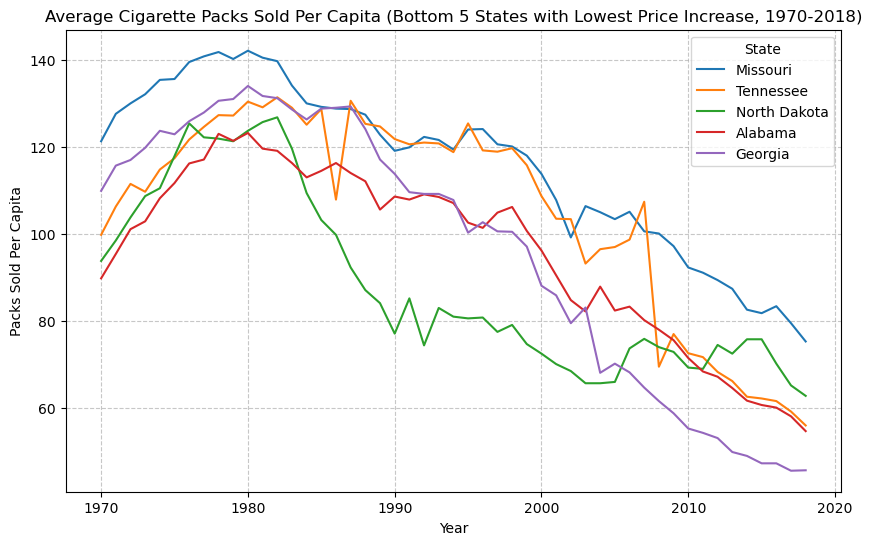

In [13]:
# Plot the trend for each of the bottom 5 states
plt.figure(figsize=(10, 6))
for state in bottom_5_states:
    plt.plot(avg_sales_per_year.index, avg_sales_per_year[state], label=state)

# Graph formatting
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.title('Average Cigarette Packs Sold Per Capita (Bottom 5 States with Lowest Price Increase, 1970-2018)')
plt.legend(title="State")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

5. Compare the trends in sales from the 5 states with the highest price increases to those with the lowest price increases.

In [ ]:
# Create separate copy for this question
df_q5 = df.copy()

# Filter for years 1970-2018
df_q5 = df_q5[(df_q5['Year'] >= 1970) & (df_q5['Year'] <= 2018)]

# Compute the first and last cigarette price for each state
price_change = df_q5.groupby("state")["price_cpi"].agg(["first", "last"])
price_change["price_increase"] = price_change["last"] - price_change["first"]

# Identify the 5 states with the highest price increase
top_5_states = price_change.nlargest(5, "price_increase").index.tolist()
print("Top 5 states with highest price increase:", top_5_states)

# Identify the 5 states with the lowest price increase
bottom_5_states = price_change.nsmallest(5, "price_increase").index.tolist()
print("Bottom 5 states with lowest price increase:", bottom_5_states)

# Filter the dataset for these states only
df_q5_top = df_q5[df_q5["state"].isin(top_5_states)]
df_q5_bottom = df_q5[df_q5["state"].isin(bottom_5_states)]

# Compute the average packs sold per capita for each group
avg_sales_top = df_q5_top.groupby('Year')['sales_per_capita'].mean()
avg_sales_bottom = df_q5_bottom.groupby('Year')['sales_per_capita'].mean()

Top 5 states with highest price increase: ['District of Columbia', 'New York', 'Rhode Island', 'Hawaii', 'Massachusetts']
Bottom 5 states with lowest price increase: ['Missouri', 'Tennessee', 'North Dakota', 'Alabama', 'Georgia']


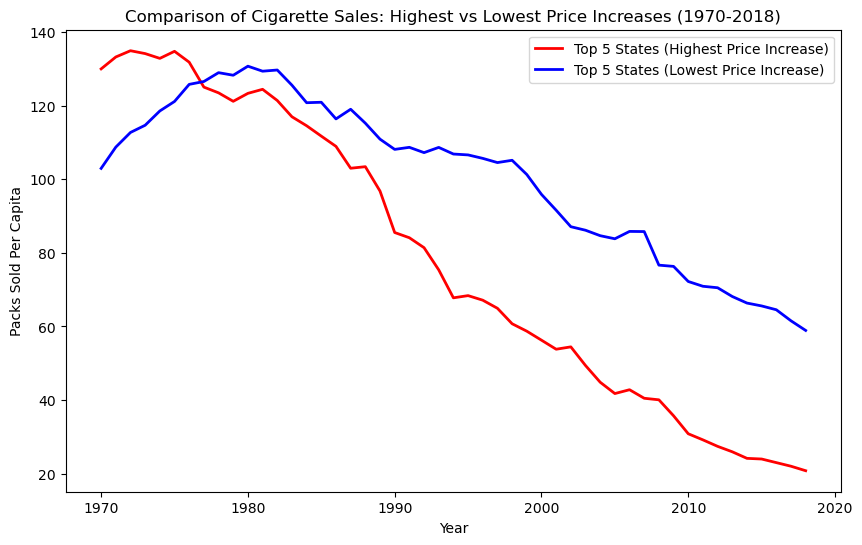

In [15]:
# Group by year and calculate mean sales_per_capita for each group (top 5 and bottom 5)

# Plot the trends for both groups
plt.figure(figsize=(10, 6))
plt.plot(avg_sales_top.index, avg_sales_top, label='Top 5 States (Highest Price Increase)', color='red', linewidth=2)
plt.plot(avg_sales_bottom.index, avg_sales_bottom, label='Top 5 States (Lowest Price Increase)', color='blue', linewidth=2)

# Format Graph
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.title('Comparison of Cigarette Sales: Highest vs Lowest Price Increases (1970-2018)')
plt.show()

The five states with the largest increases in cigarette prices saw a sharp decline in packs sold per capita from around 1970 to 2018, indicating the influence of higher prices and likely stricter tobacco control policies. In contrast, the five states with the smallest price increases experienced more stable cigarette consumption over time, with only a gradual decline. This suggests that states with smaller price hikes, many of which have historical ties to tobacco production, may have been less proactive in using price-based policies to discourage smoking.

6. Focusing only on the time period from 1970 to 1990, regress log sales on log prices to estimate the price elasticity of demand over that period. Interpret your results.

In [3]:
# Create seperate copy for this question
df_q6 = df.copy()

# Filter for years 1970-1990
df_q6 = df_q6[(df_q6['Year'] >= 1970) & (df_q6['Year'] <= 1990)]

# Take the natural log of sales_per_capita and price_cpi
df_q6['log_sales'] = np.log(df_q6['sales_per_capita'])
df_q6['log_price'] = np.log(df_q6['price_cpi'])

# Drop any rows with missing values
df_q6 = df_q6.dropna(subset=['log_sales', 'log_price'])

# Define dependent (Y) and independent (X) variables
X = sm.add_constant(df_q6['log_price'])
Y = df_q6['log_sales']

# Run and print OLS regression
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     445.1
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           6.98e-83
Time:                        15:08:22   Log-Likelihood:                 263.40
No. Observations:                1071   AIC:                            -522.8
Df Residuals:                    1069   BIC:                            -512.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3854      0.028    193.692      0.0

In [17]:
# Extract and interpret price elasticity of demand
elasticity = model.params['log_price']
print(f"Estimated Price Elasticity of Demand: {elasticity:.3f}")

# Interpretation
if elasticity < 0:
    print(f"The estimated price elasticity of demand is {elasticity:.3f}, meaning that a 1% increase in price is associated with a {-elasticity:.1f}% decrease in cigarette consumption.")
else:
    print("Unexpected result: The price elasticity estimate is positive, which is unlikely for a demand curve.")

Estimated Price Elasticity of Demand: -0.809
The estimated price elasticity of demand is -0.809, meaning that a 1% increase in price is associated with a 0.8% decrease in cigarette consumption.


7. Again limiting to 1970 to 1990, regress log sales on log prices using the total (federal and state) cigarette tax (in dollars) as an instrument for log prices. Interpret your results and compare your estimates to those without an instrument. Are they different? If so, why?

7.1

In [19]:
# Create seperate copy for this question
df_q7 = df.copy()

# Filter for years 1970-1990
df_q7 = df_q7[(df_q7['Year'] >= 1970) & (df_q7['Year'] <= 1990)]

# Take the natural log of sales, price, and tax
df_q7['log_sales'] = np.log(df_q7['sales_per_capita'])
df_q7['log_price'] = np.log(df_q7['price_cpi'])
df_q7['log_tax'] = np.log(df_q7['tax_dollar'])

# Drop any rows with  missing values
df_q7 = df_q7.dropna(subset=['log_sales', 'log_price', 'log_tax'])

# First-Stage Regresson: Predict log(price) using log(tax) 
X_first_stage = sm.add_constant(df_q7['log_tax']) #IV
Y_first_stage = df_q7['log_price'] # Endogenous variable

first_stage_model = sm.OLS(Y_first_stage, X_first_stage).fit()
df_q7['log_price_hat'] = first_stage_model.predict(X_first_stage)

print('First-Stage Regression Results:')
print(first_stage_model.summary())

First-Stage Regression Results:
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1725.
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          2.80e-225
Time:                        18:05:39   Log-Likelihood:                 1020.7
No. Observations:                1071   AIC:                            -2037.
Df Residuals:                    1069   BIC:                            -2027.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.181

7.2

In [20]:
# Second-Stage Regresson: Use predicited log(price) 
X_second_stage = sm.add_constant(df_q7['log_price_hat']) # use predicted price
Y_second_stage = df_q7['log_sales'] # dependent variable

second_stage_model = sm.OLS(Y_second_stage, X_second_stage).fit()

print("\nSecond-Stage (IV) Regression Results:")
print(second_stage_model.summary())

# Extract estimated price elasticity
elasticity_iv = second_stage_model.params["log_price_hat"]
print(f"\nIV-Estimated Price Elasticity of Demand: {elasticity_iv:.3f}")

# Compare IV Estimates to OLS Estimates 
# Re-run the simple OLS regression (from Q6) for direct comparison
X_ols = sm.add_constant(df_q7['log_price'])
ols_model = sm.OLS(Y_second_stage, X_ols).fit()
elasticity_ols = ols_model.params['log_price']

print(f"\nOLS-Estimated Price Elasticity: {elasticity_ols:.3f}")
print(f"Difference between OLS and IV Estimates: {elasticity_ols - elasticity_iv:.3f}")


Second-Stage (IV) Regression Results:
                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     330.3
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           1.56e-64
Time:                        18:15:22   Log-Likelihood:                 221.17
No. Observations:                1071   AIC:                            -438.3
Df Residuals:                    1069   BIC:                            -428.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const  

Using cigarette taxes as an instrument for prices, the estimated price elasticity of demand for cigarettes between 1970 and 1990 is -0.923. Compared to the OLS estimate of -0.809, this IV estimate suggests a greater sensitivity to price changes. The difference indicates that the OLS regression likely underestimated the true elasticity, potentially due to endogeneity bias—where factors like state-level anti-smoking campaigns or cultural attitudes toward smoking may simultaneously impact both cigarette consumption and pricing. By leveraging taxes as an instrument, the IV approach isolates the effect of external price shifts driven by policy, offering a more accurate measure of consumer responsiveness to price changes.

8. Show the first stage and reduced-form results from the instrument.

In [21]:
# Create separate copy for question
df_q8 = df.copy()
# Filter data for 1970 to 1990
df_q8 = df_q8[(df_q8['Year'] >= 1970) & (df_q8['Year'] <= 1990)]

# Take natural log of sales, price, and tax
df_q8["log_sales"] = np.log(df_q8["sales_per_capita"])
df_q8["log_price"] = np.log(df_q8["price_cpi"])
df_q8["log_tax"] = np.log(df_q8["tax_dollar"])

# Drop any rows with missing values
df_q8 = df_q8.dropna(subset=["log_sales", "log_price", "log_tax"])

# ------------ First-Stage Regresson: Predict log(price) using log(tax) ------------
X_first_stage = sm.add_constant(df_q8['log_tax']) # instrument
Y_first_stage = df_q8['log_price'] #endogenous variable

first_stage_model = sm.OLS(Y_first_stage, X_first_stage).fit()

print("\n=== First-Stage Regression: Log(Price) ~ Log(Tax) ===")
print(first_stage_model.summary())


=== First-Stage Regression: Log(Price) ~ Log(Tax) ===
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1725.
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          2.80e-225
Time:                        18:19:08   Log-Likelihood:                 1020.7
No. Observations:                1071   AIC:                            -2037.
Df Residuals:                    1069   BIC:                            -2027.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

The first stage regression shows that cigarette taxes are strongly associated with a positive relationship with cigarette prices, with a statistically significant coefficient, confirming that taxes are a strong and relevant instrument for price.

In [22]:
# ---- Reduced-Form Regression: Directly regress log(sales) on log(tax) ---- #
X_reduced_form = sm.add_constant(df_q8['log_tax']) #tax is regressor
Y_reduced_form = df_q8['log_sales'] #dependent variable

reduced_form_model = sm.OLS(Y_reduced_form, X_reduced_form).fit()
print("\n=== Reduced-Form Regression: Log(Sales) ~ Log(Tax) ===")
print(reduced_form_model.summary())


=== Reduced-Form Regression: Log(Sales) ~ Log(Tax) ===
                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     330.3
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           1.56e-64
Time:                        18:20:02   Log-Likelihood:                 221.17
No. Observations:                1071   AIC:                            -438.3
Df Residuals:                    1069   BIC:                            -428.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

9. Repeat questions 6-8 focusing on the period from 1991 to 2015.

Question 6

In [5]:
# Create separate copy for this question
df_q9_6 = df.copy()

# Filter for years 1991-2015
df_q9_6 = df_q9_6[(df_q9_6['Year'] >= 1991) & (df_q9_6['Year'] <= 2015)]

# Take the natural log of sales_per_capita and price_cpi
df_q9_6['log_sales'] = np.log(df_q9_6['sales_per_capita'])
df_q9_6['log_price'] = np.log(df_q9_6['price_cpi'])

# Drop any rows with missing values
df_q9_6 = df_q9_6.dropna(subset=['log_sales', 'log_price'])

# Define dependent (Y) and independent (X) variables
X = sm.add_constant(df_q9_6['log_price'])
Y = df_q9_6['log_sales']

# Run and print OLS regression
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     1630.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          4.20e-230
Time:                        15:09:24   Log-Likelihood:                -256.00
No. Observations:                1275   AIC:                             516.0
Df Residuals:                    1273   BIC:                             526.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6083      0.035    159.600      0.0

Question 7

In [7]:
# Create separate copy for this question
df_q9_7 = df.copy()

# Filter for years 1991-2015
df_q9_7 = df_q9_7[(df_q9_7['Year'] >= 1991) & (df_q9_7['Year'] <= 2015)]

# Take the natural log of sales, price, and tax
df_q9_7['log_sales'] = np.log(df_q9_7['sales_per_capita'])
df_q9_7['log_price'] = np.log(df_q9_7['price_cpi'])
df_q9_7['log_tax'] = np.log(df_q9_7['tax_dollar'])

# Drop any rows with  missing values
df_q9_7 = df_q9_7.dropna(subset=['log_sales', 'log_price', 'log_tax'])

# First-Stage Regresson: Predict log(price) using log(tax) 
X_first_stage = sm.add_constant(df_q9_7['log_tax']) #IV
Y_first_stage = df_q9_7['log_price'] # Endogenous variable

first_stage_model = sm.OLS(Y_first_stage, X_first_stage).fit()
df_q9_7['log_price_hat'] = first_stage_model.predict(X_first_stage)

print('First-Stage Regression Results:')
print(first_stage_model.summary())

First-Stage Regression Results:
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     8390.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:11:52   Log-Likelihood:                 874.63
No. Observations:                1275   AIC:                            -1745.
Df Residuals:                    1273   BIC:                            -1735.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.376

In [9]:
# Second-Stage Regresson: Use predicited log(price) 
X_second_stage = sm.add_constant(df_q9_7['log_price_hat']) # use predicted price
Y_second_stage = df_q9_7['log_sales'] # dependent variable

second_stage_model = sm.OLS(Y_second_stage, X_second_stage).fit()

print("\nSecond-Stage (IV) Regression Results:")
print(second_stage_model.summary())

# Extract estimated price elasticity
elasticity_iv = second_stage_model.params["log_price_hat"]
print(f"\nIV-Estimated Price Elasticity of Demand: {elasticity_iv:.3f}")

# Compare IV Estimates to OLS Estimates 
# Re-run the simple OLS regression (from Q6) for direct comparison
X_ols = sm.add_constant(df_q9_7['log_price'])
ols_model = sm.OLS(Y_second_stage, X_ols).fit()
elasticity_ols = ols_model.params['log_price']

print(f"\nOLS-Estimated Price Elasticity: {elasticity_ols:.3f}")
print(f"Difference between OLS and IV Estimates: {elasticity_ols - elasticity_iv:.3f}")


Second-Stage (IV) Regression Results:
                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     1972.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          6.43e-261
Time:                        15:15:26   Log-Likelihood:                -184.97
No. Observations:                1275   AIC:                             373.9
Df Residuals:                    1273   BIC:                             384.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const  

Question 8

In [10]:
# Create separate copy for question
df_q9_8 = df.copy()
# Filter data for 1991 to 2015
df_q9_8 = df_q9_8[(df_q9_8['Year'] >= 1991) & (df_q9_8['Year'] <= 2015)]

# Take natural log of sales, price, and tax
df_q9_8["log_sales"] = np.log(df_q9_8["sales_per_capita"])
df_q9_8["log_price"] = np.log(df_q9_8["price_cpi"])
df_q9_8["log_tax"] = np.log(df_q9_8["tax_dollar"])

# Drop any rows with missing values
df_q9_8 = df_q9_8.dropna(subset=["log_sales", "log_price", "log_tax"])

# ------------ First-Stage Regresson: Predict log(price) using log(tax) ------------
X_first_stage = sm.add_constant(df_q9_8['log_tax']) # instrument
Y_first_stage = df_q9_8['log_price'] #endogenous variable

first_stage_model = sm.OLS(Y_first_stage, X_first_stage).fit()

print("\n=== First-Stage Regression: Log(Price) ~ Log(Tax) ===")
print(first_stage_model.summary())


=== First-Stage Regression: Log(Price) ~ Log(Tax) ===
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     8390.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:17:54   Log-Likelihood:                 874.63
No. Observations:                1275   AIC:                            -1745.
Df Residuals:                    1273   BIC:                            -1735.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [11]:
# ---- Reduced-Form Regression: Directly regress log(sales) on log(tax) ---- #
X_reduced_form = sm.add_constant(df_q9_8['log_tax']) #tax is regressor
Y_reduced_form = df_q9_8['log_sales'] #dependent variable

reduced_form_model = sm.OLS(Y_reduced_form, X_reduced_form).fit()
print("\n=== Reduced-Form Regression: Log(Sales) ~ Log(Tax) ===")
print(reduced_form_model.summary())


=== Reduced-Form Regression: Log(Sales) ~ Log(Tax) ===
                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     1972.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          6.43e-261
Time:                        15:18:46   Log-Likelihood:                -184.97
No. Observations:                1275   AIC:                             373.9
Df Residuals:                    1273   BIC:                             384.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

10. Compare your elasticity estimates from 1970-1990 versus those from 1991-2015. Are they different? If so, why?

In [29]:
# Function to estimate price elasticity of demand for a given period
def estimate_elasticity(df, start_year, end_year):
    df_period = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)].copy()

    df_period["log_sales"] = np.log(df_period["sales_per_capita"])
    df_period["log_price"] = np.log(df_period["price_cpi"])

    df_period = df_period.dropna(subset=["log_sales", "log_price"])

    X = sm.add_constant(df_period["log_price"])
    Y = df_period["log_sales"]

    model = sm.OLS(Y, X).fit()

    elasticity = model.params["log_price"]
    print(f"\n=== Price Elasticity Estimate for {start_year}-{end_year} ===")
    print(model.summary())
    print(f"Estimated Price Elasticity: {elasticity:.3f}")

    return elasticity

# Estimate elasticity for 1970-1990
elasticity_1970_1990 = estimate_elasticity(df, 1970, 1990)

# Estimate elasticity for 1991-2015
elasticity_1991_2015 = estimate_elasticity(df, 1991, 2015)

# Compare the results
print("\n=== Elasticity Comparison ===")
print(f"Elasticity (1970-1990): {elasticity_1970_1990:.3f}")
print(f"Elasticity (1991-2015): {elasticity_1991_2015:.3f}")
print(f"Difference: {elasticity_1970_1990 - elasticity_1991_2015:.3f}")


=== Price Elasticity Estimate for 1970-1990 ===
                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     445.1
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           6.98e-83
Time:                        18:26:53   Log-Likelihood:                 263.40
No. Observations:                1071   AIC:                            -522.8
Df Residuals:                    1069   BIC:                            -512.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

Compared to my elasticity estimated for 1970-1990, my estimated price elasticity of demand was -0.997 for 1991-2015. The demand became more elastic in 1991-2015. This suggests consumers are more price-sensitive, though demand is still inelastic (absolute value is less than 1). This could mean that while price matters more in purchasing decisions, other factors (like addiction or brand loyalty) still play a role.